## [모듈 2.1] 사용자 정의 스크립트 (Bring Your Own Script) 로 모델 훈련
Using Scikit-learn with the SageMaker Python SDK
- https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html

Iris Training and Prediction with Sagemaker Scikit-learn
- https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_iris/scikit_learn_estimator_example_with_batch_transform.ipynb

In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


---
## Data 다운로드 및 로딩

데이터에 대한 자세한 정보는 여기를 참조 하세요. [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html)


In [31]:
# !wget http://robjhyndman.com/data/gasoline.csv

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


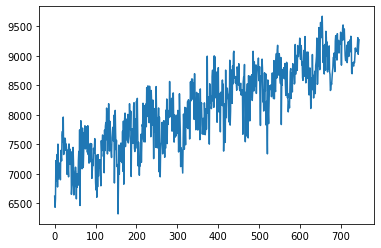

In [32]:
raw_gas = pd.read_csv('gasoline.csv', header=None, names=['thousands_barrels'])
display(raw_gas.head())
plt.plot(raw_gas)
plt.show()

## 피쳐 엔지니어링

In [33]:
def make_feature_engineering(gas):
    gas['thousands_barrels_lag1'] = gas['thousands_barrels'].shift(1)
    gas['thousands_barrels_lag2'] = gas['thousands_barrels'].shift(2)
    gas['thousands_barrels_lag3'] = gas['thousands_barrels'].shift(3)
    gas['thousands_barrels_lag4'] = gas['thousands_barrels'].shift(4)
    gas['trend'] = np.arange(len(gas))
    gas['log_trend'] = np.log1p(np.arange(len(gas)))
    gas['sq_trend'] = np.arange(len(gas)) ** 2
    weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas)], prefix='week')
    gas = pd.concat([gas, weeks], axis=1)
    
    return gas

gas = make_feature_engineering(raw_gas)

## 훈련, 검증, 테스트 데이터 세트로 분리

In [34]:

train_border=0.6
test_border=0.8
n_lags = 4 ; label = 'thousands_barrels'   
gas = gas.iloc[n_lags:, ]
split_train = int(len(gas) * train_border)
split_test = int(len(gas) * test_border)

train = gas[:split_train]
val = gas[split_train:split_test]
test = gas[split_test:]
# train_X = gas.drop(label, axis=1).iloc[:split_train, ].to_numpy()
# validation_y = gas[label][split_train:split_test]
# validation_X = gas.drop(label, axis=1).iloc[split_train:split_test, ].to_numpy()
# test_y = gas[label][split_test:]

# train_y = gas[label][:split_train]
# train_X = gas.drop(label, axis=1).iloc[:split_train, ].to_numpy()
# validation_y = gas[label][split_train:split_test]
# validation_X = gas.drop(label, axis=1).iloc[split_train:split_test, ].to_numpy()
test_y = gas[label][split_test:]
test_X = gas.drop(label, axis=1).iloc[split_test:, ].to_numpy()


In [59]:
print("test_X: ", test_X.shape)
print(train.shape)
train.head(2)

test_X:  (149, 59)
(444, 60)


,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6947.0,6875.0,7224.0,6582.0,6433.0,5,1.791759,25,0,0,...,0,0,0,0,0,0,0,0,0,0


### 데이터 파일을 로컬 및 S3에 업로드

In [60]:
import sagemaker 

def save_local(df,dir, file_name ):
    os.makedirs(dir, exist_ok=True)
    file_name_path = os.path.join(dir, file_name)
    df.to_csv(file_name_path, index=False,  header=None, float_format='%.3f')
    print(f'{file_name_path} is saved')
    
    return file_name_path

# S3 prefix
prefix = 'Scikit-byos'
train_dir = 'fe_data/train'
train_file_path = save_local(train,dir=train_dir, file_name='train.csv' )

val_dir = 'fe_data/val'
val_file_path = save_local(val,dir=val_dir, file_name='val.csv' )

test_dir = 'fe_data/test'
test_file_path = save_local(test, dir=test_dir, file_name='test.csv' )


from p_utils import upload_s3
    
bucket = sagemaker.Session().default_bucket()
prefix = 'demandforecasting'
train_file_name = 'test/train/train.csv'
s3_train_path = upload_s3(bucket, train_file_path, prefix)
s3_val_path = upload_s3(bucket, val_file_path, prefix)
s3_test_path = upload_s3(bucket, test_file_path, prefix)


fe_data/train/train.csv is saved
fe_data/val/val.csv is saved
fe_data/test/test.csv is saved
s3_path:  s3://sagemaker-ap-northeast-2-057716757052/demandforecasting/fe_data/train/train.csv
s3_path:  s3://sagemaker-ap-northeast-2-057716757052/demandforecasting/fe_data/val/val.csv
s3_path:  s3://sagemaker-ap-northeast-2-057716757052/demandforecasting/fe_data/test/test.csv


## 모델 훈련

In [37]:
instance_type = 'local'
# instance_type="ml.c4.xlarge"

In [38]:
from sagemaker import local

if instance_type == 'local':
    sess = local.LocalSession()
else:
    sess = sagemaker.Session()

In [61]:
from sagemaker import get_execution_role

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'src/train.py'


sklearn_estimator = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type= instance_type,
    role=role,
    sagemaker_session= sess,
    # bhyperparameters={'max_leaf_nodes': 30}
)

In [48]:
sklearn_estimator.fit({'train': s3_train_path}, logs=False)

Creating tmpw4uif8x7_algo-1-wkdkr_1 ... 
Attaching to tmpw4uif8x7_algo-1-wkdkr_12mdone
algo-1-wkdkr_1  | 2020-12-03 10:10:20,496 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
algo-1-wkdkr_1  | 2020-12-03 10:10:20,497 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-wkdkr_1  | 2020-12-03 10:10:20,505 sagemaker_sklearn_container.training INFO     Invoking user training script.
algo-1-wkdkr_1  | 2020-12-03 10:10:21,643 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-wkdkr_1  | 2020-12-03 10:10:21,654 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-wkdkr_1  | 2020-12-03 10:10:21,663 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-wkdkr_1  | 2020-12-03 10:10:21,671 sagemaker-training-toolkit INFO     Invoking user script
algo-1-wkdkr_1  | 
algo-1-wkdkr_1  | Training Env:
algo-1-wkd

## 모델 아티팩트 얻기

In [51]:
local_model_dir = 'model'
os.makedirs(local_model_dir, exist_ok=True)
s3_model_dir = sklearn_estimator.model_data

In [53]:
!aws s3 cp {s3_model_dir} {local_model_dir}/model.tar.gz
!tar -xzf {local_model_dir}/model.tar.gz -C {local_model_dir}

download: s3://sagemaker-ap-northeast-2-057716757052/sagemaker-scikit-learn-2020-12-03-10-10-17-801/model.tar.gz to model/model.tar.gz


In [58]:
# local_model_path = os.path.join(local_model_dir, 'model.joblib')
%store s3_model_dir
%store test_file_path
%store local_model_dir

Stored 's3_model_dir' (str)
Stored 'test_file_path' (str)
Stored 'local_model_dir' (str)


## 인퍼런스 코드 테스트

In [21]:
def input_fn(input_data, request_content_type='text/csv'):
    """
    """
    n_feature = input_data.shape[1]
    sample = input_data.reshape(-1,n_feature)
    return sample

# input for evaluation
sample = input_fn(test_X[0:10])

In [22]:
import src.inference
from importlib import reload
src.inference = reload(src.inference)

from src.inference import model_fn, predict_fn

model = model_fn('model')
predictons = predict_fn(sample, model)
print(predictons)

From user-inference file- Model loaded: 
From user-inference file- Shape of predictions:  (10,)
[9069.10210168 8982.26370473 9176.14403728 8994.43530873 9133.66802983
 9084.51546925 9137.45039398 9053.00386697 8990.91041802 8897.40776774]


In [23]:
import time
local_model_path = f'file://{os.getcwd()}/model/model.joblib'
endpoint_name = 'local-endpoint-scikit-learn-{}'.format(int(time.time()))

### Docker 명령어
로컬로드로 실행시에는 로컬에서 다커가 실행이 됩니다. 하지만 다커가 종료가 되지 않은 상태이면, 아래 명령어를 사용하여 다커를 중지 시키고 다시 실행합니다.

- 현재 실행중인 컨테이너를 보여주기
``` 
docker container ls
```
- 현재 실행중인 컨테이너를 모두 정지 시키기
```
docker stop $(docker ps -a -q)
```


requirements.txt 
- 인퍼런스시에 추가 패키지 설치

In [24]:
from sagemaker.sklearn.model import SKLearnModel
local_model = SKLearnModel(model_data = local_model_path,
                           role = role,
                           source_dir = 'src',
                           entry_point = 'inference.py',
                           framework_version = FRAMEWORK_VERSION,
                           py_version = 'py3'
                           
                          )



## 모델 배포 및 추론

In [25]:
# instance_type="ml.m5.xlarge"
# instance_type="local"

predictor = local_model.deploy(
    initial_instance_count=1,
    instance_type= instance_type,
    endpoint_name = endpoint_name,
    wait=True
    )

Attaching to tmpdkr7gblw_algo-1-ji9g0_1
algo-1-ji9g0_1  | 2020-12-03 10:00:09,258 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
algo-1-ji9g0_1  | 2020-12-03 10:00:09,260 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
algo-1-ji9g0_1  | 2020-12-03 10:00:09,261 INFO - sagemaker-containers - nginx config: 
algo-1-ji9g0_1  | worker_processes auto;
algo-1-ji9g0_1  | daemon off;
algo-1-ji9g0_1  | pid /tmp/nginx.pid;
algo-1-ji9g0_1  | error_log  /dev/stderr;
algo-1-ji9g0_1  | 
algo-1-ji9g0_1  | worker_rlimit_nofile 4096;
algo-1-ji9g0_1  | 
algo-1-ji9g0_1  | events {
algo-1-ji9g0_1  |   worker_connections 2048;
algo-1-ji9g0_1  | }
algo-1-ji9g0_1  | 
algo-1-ji9g0_1  | http {
algo-1-ji9g0_1  |   include /etc/nginx/mime.types;
algo-1-ji9g0_1  |   default_type application/octet-stream;
algo-1-ji9g0_1  |   access_log /dev/stdout combined;
algo-1-ji9g0_1  | 
algo-1-ji9g0_1  |   upstream gunicorn {
algo-1-ji9g0_1  |     server unix:/tmp/guni

In [26]:
sample = input_fn(test_X)
ridge_pred = predictor.predict(sample)


algo-1-ji9g0_1  | 2020-12-03 10:00:13,426 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
algo-1-ji9g0_1  | /miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator Ridge from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
algo-1-ji9g0_1  |   UserWarning)
algo-1-ji9g0_1  | From user-inference file- Model loaded: 
algo-1-ji9g0_1  | From user-inference file- Shape of predictions:  (149,)
algo-1-ji9g0_1  | 172.18.0.1 - - [03/Dec/2020:10:00:13 +0000] "POST /invocations HTTP/1.1" 200 1320 "-" "-"


In [27]:
import p_utils
from importlib import reload
p_utils = reload(p_utils)


from p_utils import evaluate, show_chart

Ridge-onestep-ahead MdAPE =  0.021790265344816775


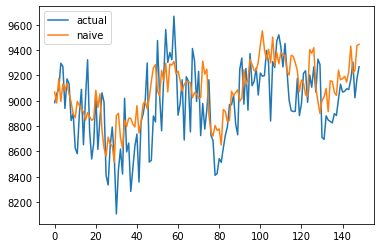

In [28]:
# Predict
# ridge_pred = predict_fn(sample, model_ridge)
# lasso_pred = predict_fn(model_lasso, sample)

# Evaluate
MdAPE = evaluate(test_y, ridge_pred)
print('Ridge-onestep-ahead MdAPE = ', MdAPE)

show_chart(test_y, ridge_pred) 

## Endpoint Cleanup

In [29]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
